In [1]:
import ROOT as R

Welcome to JupyROOT 6.22/00


In [2]:
import os
import math

In [3]:
DIR_IN = '/Users/nbartosi/pdc/muoncdata/users/bartosik/clic/studies/2020_12_22_tracking/digi'
FILES_IN = [os.path.join(DIR_IN, name) for name in ['pgun_mumi_100k_mod4_OverlayBIB_fixedBIB_allHits_m1p0_0p15.root', 
                                                    'pgun_mumi_100k_mod4_OverlayBIB_fixedBIB_allHits_m5p0_0p3.root']]

### Getting hit multiplicity histograms

In [79]:
LAYERS = {'b': range(8), 'e': range(8)}
histos = {}
fIn = R.TFile(FILES_IN[0])
fIn.cd()
for subdet, folder in {'b': 'FilterDL_VXDB', 'e': 'FilterDL_VXDE'}.items():
    fIn.cd(folder)
    for l in LAYERS[subdet]:
        hname = 'h_nSensorHits_layer_{0:d}'.format(l)
        h = R.gDirectory.Get(hname).Clone()
        h.SetDirectory(0)
        R.SetOwnership(h, False)
        histos[(subdet, l)] = h
fIn.Close()

In [163]:
h_dens = {det: R.TH1F('h_dens_{0:s}'.format(det), ';Layer;Hit density [cm^{-2}]', 16,0,16) for det in ['b', 'e']}
h_occup = {pitch: R.TH1F('h_occup_{0:d}'.format(pitch), ';Layer;Sensor occupancy [%]', 16,0,16) for pitch in [25,50,100,200]}

Warning in <TROOT::Append>: Replacing existing TH1: h_dens_b (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_dens_e (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_occup_25 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_occup_50 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_occup_100 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_occup_200 (Potential memory leak).


In [164]:
colors = {'b': R.kGray+1, 'e': R.kPink+1}
for det, offset in {'b': 0, 'e': 8}.items():
    for l in LAYERS[det]:
        h_dens[det].SetBinContent(l+1+offset, hit_dens[(det, l)])
    h_dens[det].SetFillColor(colors[det])
    h_dens[det].SetLineColor(1)
    h_dens[det].SetLineWidth(2)
    for pitch in [25,50,100,200]:
        for l in LAYERS[det]:
            h_occup[pitch].SetBinContent(l+1+offset, sens_occup[((det, l), pitch)])

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file /Users/nbartosi/pdc/muoncdata/users/bartosik/clic/studies/2020_04_21_tracker/digi/plots/hit_density_vtx.pdf has been created


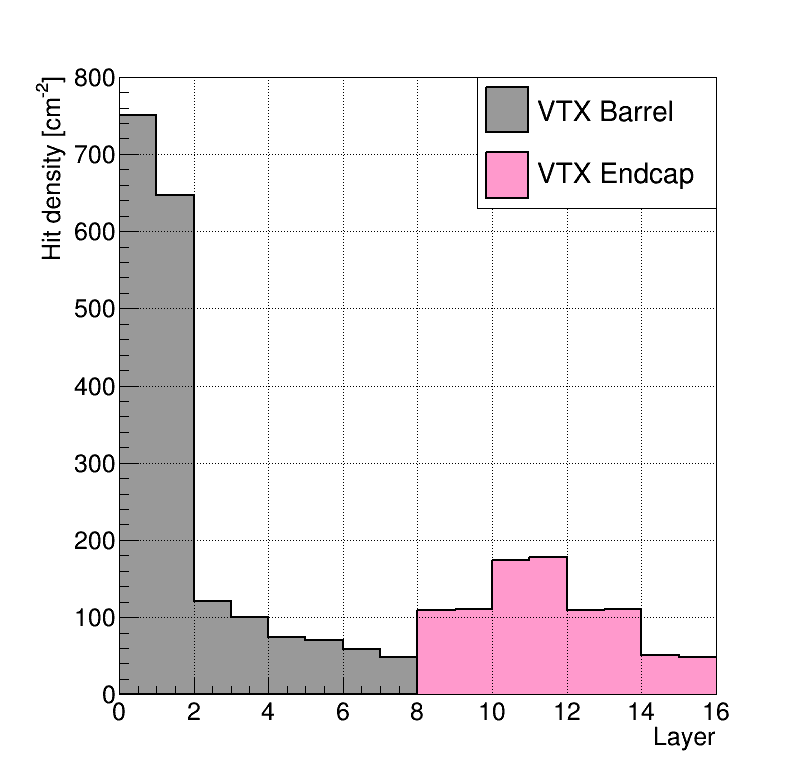

In [189]:
C = R.TCanvas('c1', '', 800,800)
C.SetLeftMargin(0.15)
C.SetGrid(1,1)
R.gStyle.SetOptStat(0)
C.Clear()
leg = R.TLegend(0.6,0.73,0.9,0.9)
h_dens['b'].SetAxisRange(0, 800, 'Y')
h_dens['b'].Draw()
h_dens['e'].Draw('same')
h_dens['b'].Draw("AXIG same")
leg.AddEntry(h_dens['b'], 'VTX Barrel', 'f')
leg.AddEntry(h_dens['e'], 'VTX Endcap', 'f')
leg.Draw()
C.Draw()
C.SaveAs(os.path.join(DIR_IN, 'plots/hit_density_vtx.pdf'))

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2
Info in <TCanvas::Print>: pdf file /Users/nbartosi/pdc/muoncdata/users/bartosik/clic/studies/2020_04_21_tracker/digi/plots/sensor_occupancy_vtx.pdf has been created


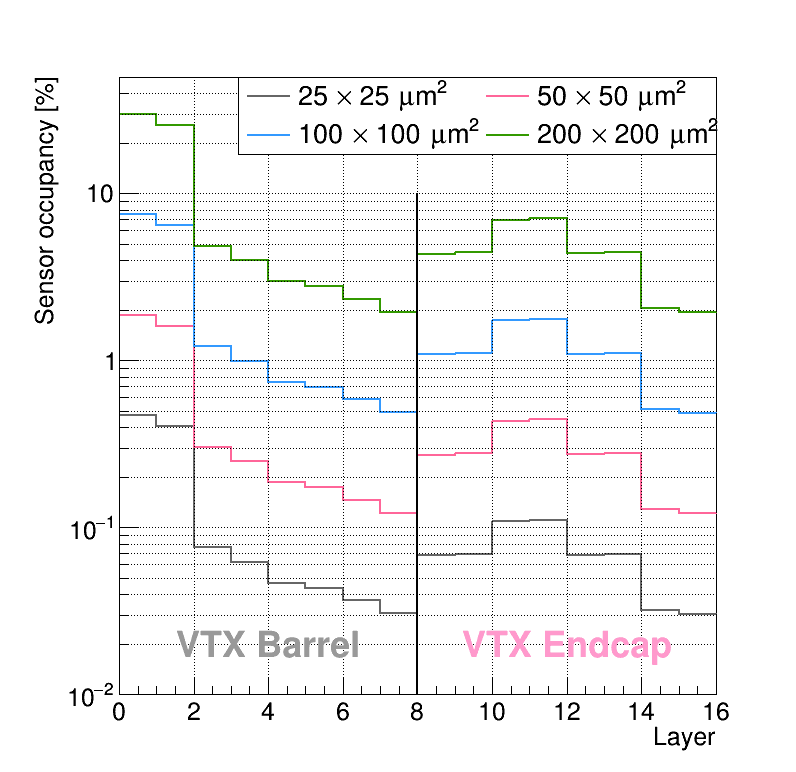

In [211]:
colors = {25: R.kGray+2, 50: R.kPink-4, 100: R.kAzure+1, 200: R.kSpring-6}
C = R.TCanvas('c2', '', 800,800)
C.SetLeftMargin(0.15)
C.SetGrid(1,1)
R.gStyle.SetOptStat(0)
C.Clear()
leg = R.TLegend(0.3,0.8,0.9,0.9)
leg.SetNColumns(2)
h_ax = None
for iH, pitch in enumerate([25,50,100,200]):
    h = h_occup[pitch]
    if iH == 0:
        h_ax = h
        h.SetAxisRange(0.01, 50, 'Y')
    drawopt = '' if iH == 0 else 'same'
    h.SetLineColor(colors[pitch])
    h.SetLineWidth(2)
    h.Draw(drawopt)
    leg.AddEntry(h, '{0:d} #times {0:d} #mum^{{2}}'.format(pitch), 'L')
h_ax.Draw("AXIG same")
# Drawing line
line = R.TLine(8,0,8,10)
line.SetLineColor(1)
line.SetLineWidth(2)
line.Draw()
# Drawing text
tb = R.TText(4, 2e-2, 'VTX Barrel')
tb.SetTextAlign(22)
tb.SetTextColor(R.kGray+1)
tb.Draw()
te = R.TText(12, 2e-2, 'VTX Endcap')
te.SetTextAlign(22)
te.SetTextColor(R.kPink+1)
te.Draw()
leg.Draw()
C.SetLogy()
C.Draw()
C.SaveAs(os.path.join(DIR_IN, 'plots/sensor_occupancy_vtx.pdf'))

## Calculating the mean/max hit mulptiplicities in each layer: VTX

In [21]:
sens_area = {}  # in mm
for sub in range(2):
    sens_area.update({('b', l*2+sub): 130*a for l, a in enumerate([16*13, 15*23, 21*24, 29*24])})
er_max = 115-3
for sub in range(2):
#     sens_area.update({('e', l*2+sub): math.tan(math.pi/16)*(r+1+er_max+1)*(er_max-r) for l, r in enumerate([22+3, 28+3, 35+3, 50+3])})
    sens_area.update({('e', l*2+sub): math.pi*(r+er_max)*(er_max-r) for l, r in enumerate([22+3, 28+3, 35+3, 50+3])})
print(sens_area)
hit_mult = {}
hit_dens = {}
sens_npix = {}
sens_occup = {}
# for det, h in histos.items():
# #     nhits = h.GetMean()
#     nhits = h.GetBinCenter(h.FindLastBinAbove(0))
#     sens_npix[det] = sens_area[det] / (25*25 / 1e6)
#     hit_mult[det] = nhits
#     hit_dens[det] = nhits / (sens_area[det] / 1e2)
#     for pitch in [25,50,100,200]:
#         sens_occup[(det, pitch)] = 1e2 * nhits / (sens_area[det] / (pitch*pitch / 1e6))

{('b', 0): 27040, ('b', 2): 44850, ('b', 4): 65520, ('b', 6): 90480, ('b', 1): 27040, ('b', 3): 44850, ('b', 5): 65520, ('b', 7): 90480, ('e', 0): 37444.642838136744, ('e', 2): 36389.06770653057, ('e', 4): 34871.678454846704, ('e', 6): 30583.404482696635, ('e', 1): 37444.642838136744, ('e', 3): 36389.06770653057, ('e', 5): 34871.678454846704, ('e', 7): 30583.404482696635}


In [22]:
sens_area

{('b', 0): 27040,
 ('b', 2): 44850,
 ('b', 4): 65520,
 ('b', 6): 90480,
 ('b', 1): 27040,
 ('b', 3): 44850,
 ('b', 5): 65520,
 ('b', 7): 90480,
 ('e', 0): 37444.642838136744,
 ('e', 2): 36389.06770653057,
 ('e', 4): 34871.678454846704,
 ('e', 6): 30583.404482696635,
 ('e', 1): 37444.642838136744,
 ('e', 3): 36389.06770653057,
 ('e', 5): 34871.678454846704,
 ('e', 7): 30583.404482696635}

In [12]:
sens_area
arr_vtx = 0
for key, a in sens_area.items():
    if 'e' in key:
        arr_vtx += a
print('Vertex', int(arr_vtx), 'mm^2')

Vertex 17877 mm^2


### Inner/Outer Barrel

In [13]:
l = [2*481.6, 2*481.6, 2*692.3] + [2*1264.2, 2*1264.2, 2*1264.2]
r = [127, 340, 554] + [819, 1153, 1486]
arr_barrel = 0
for iL in range(6):
    arr = 2*math.pi*r[iL]*l[iL]
    print(arr)
    arr_barrel += arr
print('Barrel', int(arr_barrel*1.1), 'mm^2')

768599.439160173
2057667.7898776284
4819632.900481753
13010966.293421078
18317025.807465814
23607198.915779877
Barrel 68839200 mm^2


### Inner/Outer Endcap

In [17]:
ro = [405] + [555]*6 + [1430.2] * 4
ri = [95, 147, 190, 212, 237, 264, 284]  +  [617.5] * 4
arr_endcap = 0
for iL in range(11):
    arr = math.pi*(ro[iL]**2) - math.pi*(ri[iL]**2)
    print(arr)
    arr_endcap += arr
print('Endcap', int(arr_endcap*1.1), 'mm^2')

486946.8613064179
899802.4014705741
854277.5823274044
826493.3368990563
791228.9593625108
748732.6355374018
714300.7800540576
5228131.020219455
5228131.020219455
5228131.020219455
5228131.020219455
Endcap 28857737 mm^2


### ECAL

In [31]:
l = 2*2210
ri = 1740
ro = 3330
vol = (math.pi*(ro**2) - math.pi*(ri**2)) * l
print('ECAL Barrel', vol/1e9, 'm^3')

l = 2*(2509 - 2307)
ri = 310
ro = 1700
vol += (math.pi*(ro**2) - math.pi*(ri**2)) * l
print('ECAL Total', vol/1e9, 'm^3')

ECAL Barrel 111.93791819405463 m^3
ECAL Total 115.4839456628599 m^3


### HCAL

In [32]:
l = 2*2210
ri = 1500
ro = 1702
vol = (math.pi*(ro**2) - math.pi*(ri**2)) * l
print('HCAL Barrel', vol/1e9, 'm^3')

l = 2*(4129 - 2539)
ri = 445
ro = 3246
vol += (math.pi*(ro**2) - math.pi*(ri**2)) * l
print('HCAL Total', vol/1e9, 'm^3')

HCAL Barrel 8.981416550629216 m^3
HCAL Total 112.26567760250654 m^3


In [201]:
1.0/(50*50*1e-8)

40000.0

In [18]:
math.tan(math.pi/16)

0.19891236737965798

In [20]:
math.pi

3.141592653589793

In [26]:
math.pi*(115**2 - 25**2)

39584.067435231394

In [27]:
math.pi*(115-25)**2

25446.900494077323